# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации `Shift+Tab`. Нажатие `Tab` после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, scale
from sklearn.utils import shuffle

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __`pandas.read_csv`__ в переменную __`df`__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('../data/bikes_rent.csv')
df.sample(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
620,3,1,9,0,3,1,1,24.565847,28.50375,57.7083,8.833682,3.948897,7870
490,2,1,5,0,6,0,2,25.488347,29.23040,75.6667,10.250464,4.582237,6883
513,2,1,5,1,1,0,1,29.212500,33.96500,67.6250,13.166907,5.885966,6043
142,2,0,5,0,1,1,2,25.898347,29.51480,81.0000,15.667414,7.003761,4274
315,4,0,11,0,6,0,1,14.623347,17.89710,55.2917,14.208154,6.351432,4067


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* `season`: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* `yr`: 0 - 2011, 1 - 2012
* `mnth`: от 1 до 12
* `holiday`: 0 - нет праздника, 1 - есть праздник
* `weekday`: от 0 до 6
* `workingday`: 0 - нерабочий день, 1 - рабочий день
* `weathersit`: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* `temp`: температура в Цельсиях
* `atemp`: температура по ощущениям в Цельсиях
* `hum`: влажность
* `windspeed(mph)`: скорость ветра в милях в час
* `windspeed(ms)`: скорость ветра в метрах в секунду
* `cnt`: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальными признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных.

In [3]:
target = ['cnt']
numeric_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
categorial_features = [col for col in df.columns if col not in target + numeric_features]

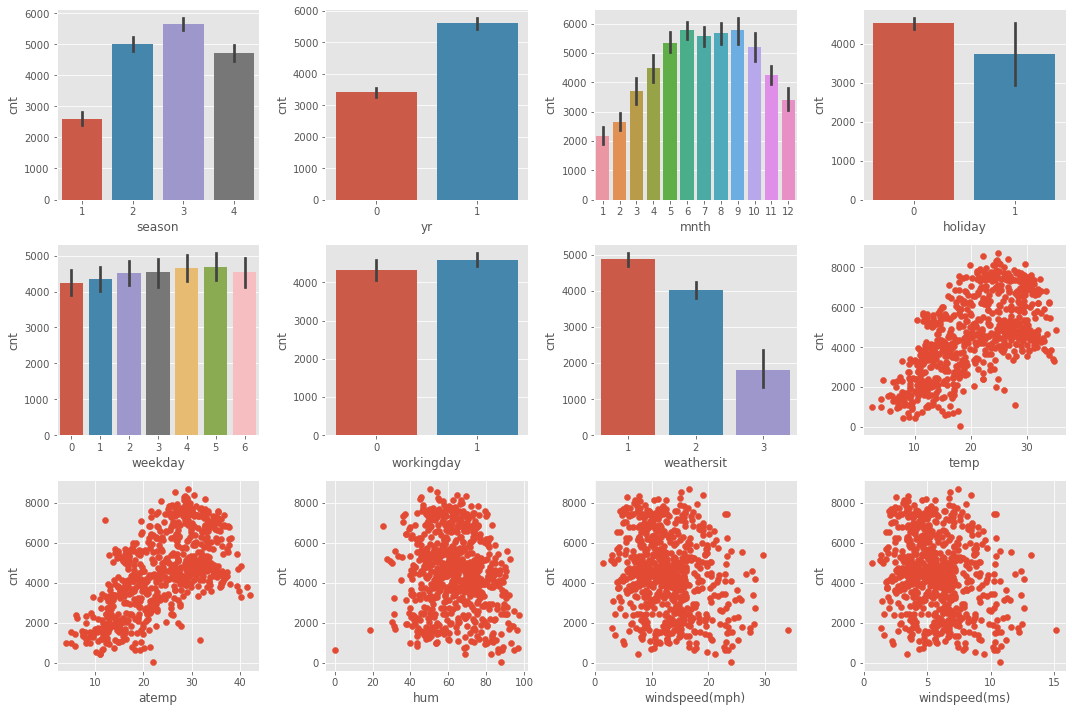

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    #df.plot(feature, 'cnt', subplots=True, kind='scatter', ax=axes[int(idx / 4), idx % 4])
    if feature in numeric_features:
        plt.subplot(3, 4, idx+1)
        plt.scatter(x=df.loc[:, feature], y=df.loc[:, 'cnt'])
        plt.ylabel('cnt')
        plt.xlabel(feature)
    else:
        plt.subplot(3, 4, idx+1)
        sns.barplot(x=df.loc[:, feature], y=df.loc[:, 'cnt'])
fig.tight_layout()
plt.show()


------

### Блок 1. Ответьте на вопросы (каждый 0.5 балла):

1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: Количество прокатов велосипедов начинает ратсти с начала года и достигает плато в период с мая по сентябрь, после идет на спад 
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: temp и atemp. Зависимость примерно одинаковая т.к. эти векторы скорее всего сильно коррелированы между собой
   
------

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: `corr` и `corrwith`. Метод `df.corr` вычисляет матрицу корреляций всех признаков из датафрейма. Методу `df.corrwith` нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из `df` и этого датафрейма.

In [5]:
df.corr().style.background_gradient(cmap='coolwarm')

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [6]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df.iloc[:, 7:].corr().style.background_gradient(cmap='coolwarm')

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: `temp` и `atemp` (коррелируют по своей природе) и два `windspeed` (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод `mean`), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [7]:
# Код 1.3 (0.5 балла)
df[['yr', 'holiday', 'workingday']].mean()

yr            0.500684
holiday       0.028728
workingday    0.683995
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода `scale`.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [8]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled['cnt']

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [9]:
lin_regression = LinearRegression()
lin_regression.fit(X, y)
for name, coef in zip(df.columns[:-1], lin_regression.coef_):
    print (name, coef)

season 570.8681698112806
yr 1021.9637175294769
mnth -141.30232005185658
holiday -86.76357810238395
weekday 137.2291962130855
workingday 56.38823527436251
weathersit -330.2316126526911
temp 367.4749136050979
atemp 585.5563613048682
hum -145.60790584172227
windspeed(mph) 12458830091266.607
windspeed(ms) -12458830091465.062


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в `X` есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такую ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой `temp-atemp` чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Решение проблемы мультиколлинеарности состоит в __регуляризации__ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется __Lasso__, а во втором — __Ridge__. Подробнее об этом также было рассказано в лекции.

Обучите регрессоры `Ridge` и `Lasso` с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [10]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией
ridge_regression = Ridge()
ridge_regression.fit(X, y)
for name, coef in zip(df.columns[:-1], ridge_regression.coef_):
    print (name, coef)

season 563.0645722520176
yr 1018.9483787875288
mnth -131.87332028247695
holiday -86.74609799709272
weekday 138.005111178719
workingday 55.90311037506445
weathersit -332.34978849907355
temp 386.45788919194615
atemp 566.3470470600289
hum -145.0713272986722
windspeed(mph) -99.25944108175416
windspeed(ms) -99.25944115437945


In [11]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией
lasso_regression = Lasso()
lasso_regression.fit(X, y)
for name, coef in zip(df.columns[:-1], lasso_regression.coef_):
    print (name, coef)

season 560.241616030887
yr 1019.4634940657196
mnth -128.7306270367875
holiday -86.15278133371096
weekday 137.34789390496329
workingday 55.21237064135668
weathersit -332.3698569623488
temp 376.3632362096987
atemp 576.5307935045507
hum -144.12915500348595
windspeed(mph) -197.13968940248608
windspeed(ms) -2.8049652690829766e-08


------

### Блок 2.  Поясните, 

каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.

* __Ваш ответ (1 балл)__: L2 не решает проблему мультиколлиниарности в то время, когда l1 решает, она зануляет такого рода признаки. Однако оба вида регуляризации занизили веса и решили проблему переобучения.

------

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [12]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
for idx, alpha in enumerate(alphas):
    lasso_regression = Lasso(alpha=alpha)
    ridge_regression = Ridge(alpha=alpha)
    lasso_regression.fit(X, y)
    ridge_regression.fit(X, y)
    coefs_lasso[idx] = lasso_regression.coef_
    coefs_ridge[idx] = ridge_regression.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

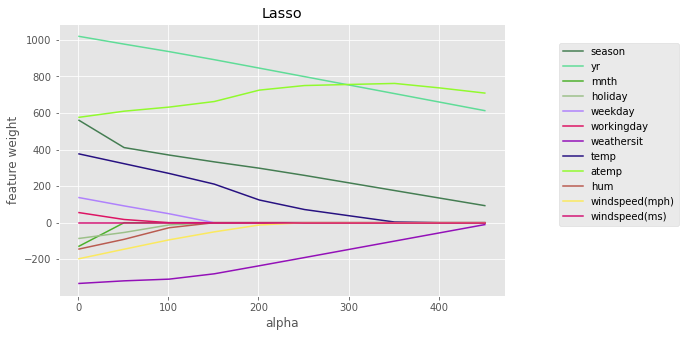

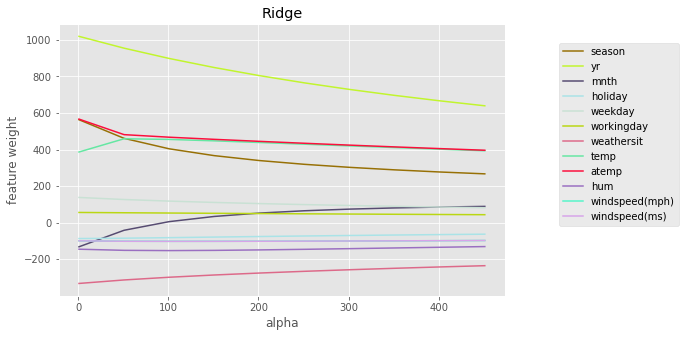

In [13]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

------

### Блок 3. Ответьте на вопросы (каждый 0.25 балла):

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же `alpha`?
    * Ответ: Лассо
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: Многие признаки объектов обнулятся
1. Можно ли утверждать, что Lasso исключает один из признаков `windspeed` при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: лассо обнулит, а ридж нет 
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: лассо
    
------

Далее будем работать с Lasso.

Итак, мы видим, что при изменении `alpha` модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее `alpha`. 

Для этого, во-первых, нам __нужна метрика качества__. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, __на каких данных эту метрику считать__. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные «новые» данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения `alpha`, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на `K` частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из `alpha` и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера `len(alpha) x k`, `k = 3` (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по `alphas`; для сопоставления с матрицей MSE лучше использовать переменную регрессора `alphas`.

In [14]:
scorer = make_scorer(mean_squared_error, greater_is_better = True)
KFold_cv = KFold(n_splits=3)
alphas = np.arange(1, 100, 5)
lasso_cv_model = LassoCV(alphas=alphas, cv=KFold_cv)
lasso_cv_model.fit(X, y)

LassoCV(alphas=array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]),
        cv=KFold(n_splits=3, random_state=None, shuffle=False))

In [15]:
print(
    max(
        [[alpha, value.mean()] for alpha, value in zip(lasso_cv_model.alphas_, lasso_cv_model.mse_path_)], 
        key=lambda x: x[1],
    )[0]
)

96



Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [16]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
mses = []
for alpha in alphas:
    lasso_reg = Lasso(alpha=alpha)
    lasso_reg.fit(X, y)
    mses.append([alpha, mean_squared_error(y, lasso_reg.predict(X))])
alpha, max_value = max(mses, key=lambda i_v: i_v[1])
lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X, y)
df_check = pd.DataFrame(data=lasso_reg.coef_, index=df.columns[:-1], columns=['coefs'])
for name, coef in zip(df.columns[:-1], lasso_reg.coef_):
    print (name, coef)
print (alpha)

season 374.1514457340241
yr 940.046508351147
mnth 0.0
holiday -16.726356765918
weekday 53.20422590207222
workingday 0.0
weathersit -309.58845457491617
temp 274.90845004302366
atemp 630.2102004466686
hum -33.93358130522256
windspeed(mph) -98.9465110531558
windspeed(ms) -2.406747430746435e-08
96


In [17]:
df_check.sort_values('coefs', ascending=False)

,coefs
yr,9.400465e+02
atemp,6.302102e+02
season,3.741514e+02
temp,2.749085e+02
weekday,5.320423e+01
mnth,0.000000e+00
workingday,0.000000e+00
windspeed(ms),-2.406747e-08
holiday,-1.672636e+01
hum,-3.393358e+01


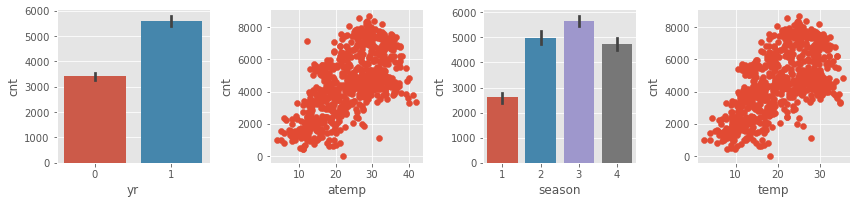

In [18]:
plt.figure()
for idx, feature in enumerate(df_check.sort_values('coefs', ascending=False).index[:4].values):
    if feature in numeric_features:
        plt.subplot(3, 4, idx+1)
        plt.scatter(x=df.loc[:, feature], y=df.loc[:, 'cnt'])
        plt.ylabel('cnt')
        plt.xlabel(feature)
    else:
        plt.subplot(3, 4, idx+1)
        sns.barplot(x=df.loc[:, feature], y=df.loc[:, 'cnt'])
plt.tight_layout()
plt.show()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

------

### Блок 4. Ответьте на вопросы (каждый 0.5 балла):

1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке «Знакомство с данными». Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ:
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ:
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ:

_Чтобы получить максимальный балл за задание, постарайтесь отвечать развёрнуто, не ограничиваясь односложными «да» или «нет»._

------

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.